# A recommender for one (Work in Progress)
___

### Data & Project Overview
___
Columns:
* tweet - A data science related tweet, tweeted in spring 2021
* Prefer - I personally labeled if that tweet catches my attention (could be content, humor or other reasons)

A friend introduced me to the data science communities on Twitter a while ago & I was really excited to get involved!
Through these tweets, I hope to uncover the unconscious areas of data science that may most excite me at any given time & get in touch with people & communities that are engaging with them. 

This will involve exploratory analysis to find trends of interest. And preparing a recommendation engine that recommends specific tweets. About 20% of the dataset tweets excite me, so the hope would be to build a model that has an accuracy significantly above 20%.

In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# Installing textstat package
!pip install textstat

In [4]:
!pip install folium

/Users/ammarkhan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



     |████████████████████████████████| 94 kB 2.9 MB/s eta 0:00:01


In [5]:
# Necessary modulaes
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 

/Users/ammarkhan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [6]:
# Utility functions
#utility functions:
def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

In [229]:
# Importing data
tweet_data = pd.read_csv('Data/df12.csv', index_col = 0)
tweet_data.reset_index(drop=True, inplace=True)

In [131]:
# Glimpse
tweet_data.head()

,tweet,Prefer
0,Expanding the #DataScience Graduate Programme ...,0
1,Hooked on Netflix 🎬🍿? Do you know how recommen...,0
2,12 Steps to Applied AI. #Python #BigData #Anal...,1
3,me learning #DataScience https://t.co/4n8cKf2xk8,0
4,Check out my #Gig on Fiverr https://t.co/P8Sk...,0


In [230]:
# Basic cleaning
tweet_data['tweet'] = tweet_data['tweet'].apply(lambda x:cleanhtml(x))

In [231]:
#removing url tags
tweet_data['tweet'] = tweet_data['tweet'].apply(lambda x:removeurl(x))

## 1. Target Value Distribution

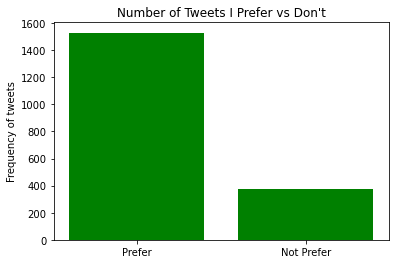

In [30]:
energy = [(tweet_data['Prefer'] == 0).sum(),(tweet_data['Prefer'] == 1).sum()]

x_pos = ['Prefer', 'Not Prefer']

plt.bar(x_pos, energy, color='green')
plt.ylabel("Frequency of tweets")
plt.title("Number of Tweets I Prefer vs Don't")

plt.show()

In [32]:
energy[1] / (energy[0] + energy[1])

0.19568648079957918

In total I felt 19.5% I sampled had serendipity potential.

## 2. Word Clouds of each class

In [34]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 4.9 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=157852 sha256=07da5d9829998229546184ed6836a78317a494d85a03a7fd118e57ab1bac3f93
  Stored in directory: /Users/ammarkhan/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud


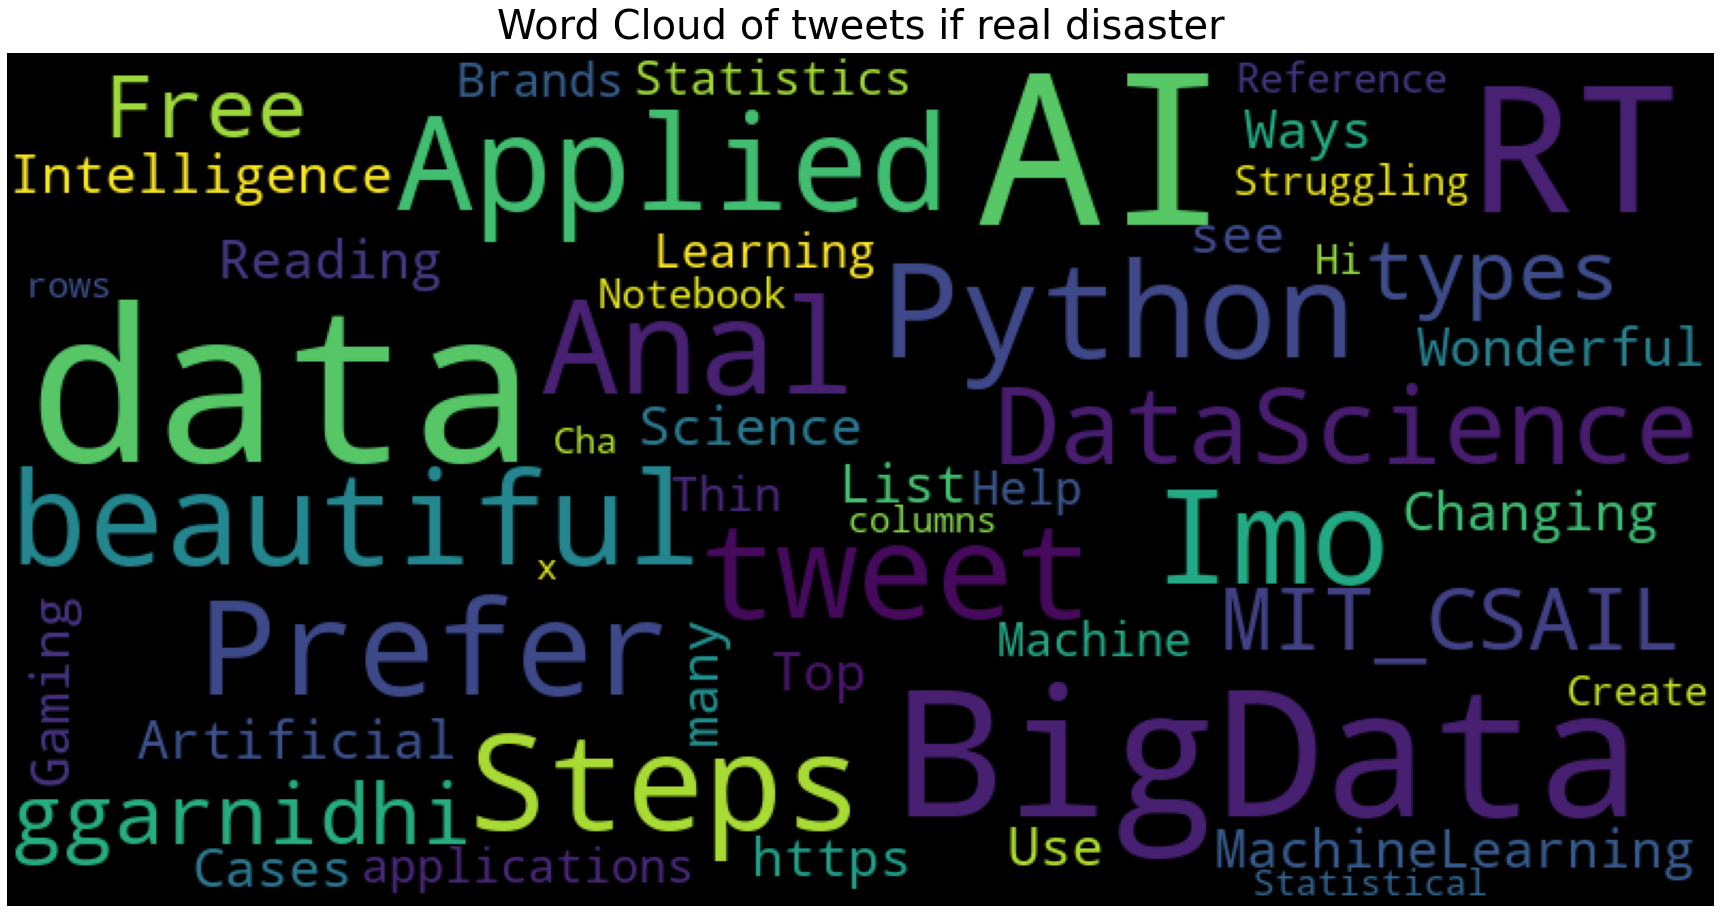

In [35]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(tweet_data[tweet_data["Prefer"]==1], title="Word Cloud of tweets if real disaster")

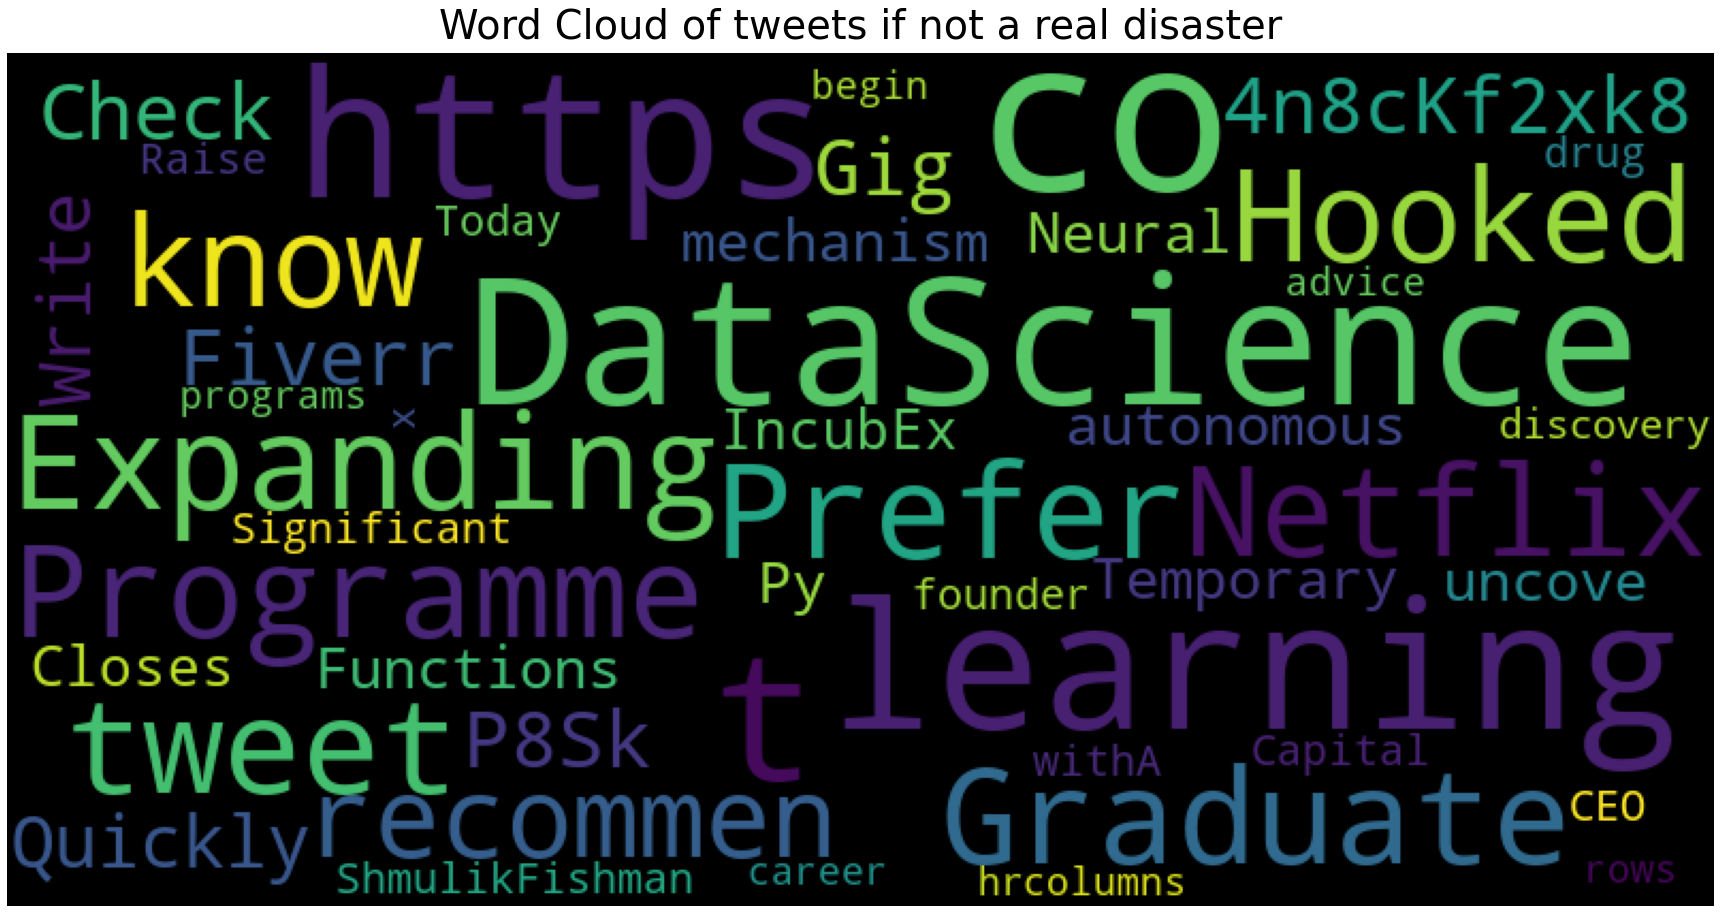

In [37]:
plot_wordcloud(tweet_data[tweet_data["Prefer"]==0], title="Word Cloud of tweets if not a real disaster")

Note pattern of 'applied theme': Applied AI, Cases, Applications, beautiful.

## 3. Word Frequencies of each class

To later add bigram & trigram plots as well.

## 4. Vanilla Model

In [136]:
tweet_data.head()

,tweet,Prefer
0,Expanding the #DataScience Graduate Programme ...,0
1,Hooked on Netflix 🎬🍿? Do you know how recommen...,0
2,12 Steps to Applied AI. #Python #BigData #Anal...,1
3,me learning #DataScience https://t.co/4n8cKf2xk8,0
4,Check out my #Gig on Fiverr https://t.co/P8Sk...,0


In [232]:
# Divide into train test
y = tweet_data['Prefer']
X = tweet_data['tweet']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 40,
                                                   stratify = y) 

In [233]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [155]:
X_train.shape

(1273,)

In [156]:
y_train.shape

(1273,)

In [234]:
from sklearn.feature_extraction.text import CountVectorizer

bagofwords = CountVectorizer(stop_words="english")
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train) 
X_test_transformed = bagofwords.transform(X_test) 

X_train_transformed.shape

(1273, 6942)

In [239]:
# Fitting a model
logreg0 = LogisticRegression(C = 0.1)
logreg0.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg0.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg0.score(X_test_transformed, y_test)}")

Train score: 0.8366064414768264
Test score: 0.7977707006369427


Initial test score bump up from 19.5% to 79%. 
To consider adding confusion matrix later.

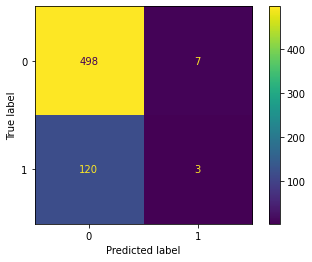

In [240]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = logreg0.predict(X_test_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

## 5. Feature Engineering

In [241]:
train_full = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_train_transformed.toarray())
test_full = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_transformed.toarray())

In [170]:
train_full.head()

,00,000,000km,00ejoqlnin,02,03,04,05,05aol2mnvq,070ptix4hf,08,0a7naghs9l,0cobkwukzh,0d2sjwrcjw,0djyh87spv,0epubuwebz,0ftu45euus,0fwuhgu1kd,0gkhkgu8oz,0gwlwhp67w,0ilc1xuwsp,0iqgnlpvdz,0k66z7a1q7,0kpxrr2mkx,0l4ldaxtlo,0pxngj1xge,0uhdfcvs1i,0vre8z561e,0xzr3te52y,0y3ki8q8e0,10,100,100da,100days,100daysofc,100daysofcode,100daysofcodechallenge,100daysofgamedev,100daysofmlcode,100daysofpython,101,10k,10million,10th,10x,11,116ljirzzk,12,12ne7ibjvv,13,130,134,14600,15,150,15043,15450,155m,15pbjgvfok,15th,16,169,17,171,17th,18,189,19,1920s,199,1anwk5pwdi,1ashdvkxup,1d6bnruace,1edgxj2lyf,1ffkqbkqhd,1fkm8xl0on,1gnri963d0,1i6uged0gd,1iiggeazif,1krpyglk04,1l,1m2fzuar3y,1molv8nyna,1mzjgf9q5t,1ota29b0nv,1p2u6vyxls,1rcevze0eo,1sbojolepz,1sok1ssk1r,1spatial,1st,1stmai,1suinhcj3j,1tfnna3c72,1to4nkfevj,1txhqn6ezr,1up7p2f6an,1v8mo3x43s,1wchaqpsiy,1x1drhmwwt,1y4txk8tda,1z4vfkhwjv,1zefzrcm2o,20,200,2008,201,2017,2019,2020,2021,2021mayopinions,2022,2025,2026,2027,2028,209,20cm,20k,20mins,20rfjnp8fx,21,2100,217,21st,22,23,24wuadtl6r,25,250,26,267,27th,28,29,2al9nmfn8t,2basetechnologies,2bkmfgoosf,2clearb4that,2d,2dgmwyau7n,2dip,2ecpf0un61,2efisqs5xt,2fnn7txegm,2fxbaomc1p,2htwhu0xdf,2lhntdgctd,2mmbecjhed,2nd,2qgqog4pho,2rblrzxfst,2tdrq2sons,2vgkis91cl,2wwmu349pi,2xwjoflkn5,2ypln3v0sp,30,300,301st,30daysofcode,321,32qhnl4b8q,331,35,35m,36ljcpzdkf,3700,39,395,3blcjsuzcc,3d,3dprinting,3f5koelamn,3ic8jtni1n,3jn9xl5d53,3l6bokrh10,3ld0bsei5e,3li3lwbm9w,3novices,3oxjtftl8u,3p0qcffjup,3p7s7hl7bu,3rd,3sc0x0q8jc,3slbl8xyw3,3snrjkjzrh,3states,3tvwd1u9fi,3ud3no5mke,3x,3ywwfe7zwx,3zyrxfsx7z,40,408,411,412ibljqjf,42b,42tfkqvwx9,43zwqpvsvl,44maiwbb7c,45,4500,475notiyqt,499,4cudov8fxj,4d6rnpxkni,4dbavqipvs,4e,4em5zjezmt,4gad4q2ud0,4gixmjsdno,4hcdnolb05,4jvnuvwolx,4lcdqypxdy,4liqnkmwxn,4m5hi5hqab,4mu0wklm4r,4mwrkla60e,4mzcqfxxbj,4n8ckf2xk8,4nrrc72p2v,4re9bxi131,4scoesfywp,4skbmgxx9l,4th,4v,4wepoz6aec,4y2vsfrytp,50,500,50k,51,510,518,51fepxoe68,53tqd0ziym,56e6b3byde,56eqbrsma6,56okemuhxl,56tjsz4sai,57kqm4mvzd,584,59,592nlp3vqw,59wqeunzl8,5bgx8dk5pu,5dtmhu3jky,5e0xkpwqxn,5fhgvmfgkx,5g,5hkpb5wya2,5j34vyhuae,5jafg1tdqc,5kd2c7acqo,5lpa8ihuc4,5mins,5ocehalayg,5pd04lirsf,5pm,5rrrwtw1be,5sxjgoqyui,5t5wvmg0te,5uyjg4e1qq,60,60krerdvdv,6320,63sx1t53qs,64wtzuj9ta,66dayaofdata,66daysofdata,67,67jefdqmsi,68qrpwkb5j,69,69ujkqxvlg,6ah5wlazly,6amwcnzsqz,6fcjfkewo9,6igw2csfkb,6iveqd5cpb,6ixlheskcb,6j5e0lkied,6j7rxmooiz,6jthdxmump,6kjz8mmuuw,6kswl7iefu,6lmmhwjb2n,6nu8cvrxzt,6o2squsggj,6pqzyyvywj,6s9xf96h75,6th,6utb7qgb5k,70,710,71xjd5ocud,72,720m,722,75rx6cjmlm,75yo57wvs0,76j65oulbr,76yfc2ehex,7707fn7b8x,77gtr2eerm,79,7abjml9h2k,7acl7jm0pl,7atrpjlvnt,7gomp4lqlk,7h6ozcwatm,7i7qhseohf,7isshj9rvs,7iwkmmpkct,7khc0mocrh,7mj4hf31ox,7osi1mixag,7rkkxtsiml,7th,7vrpfgr7na,7wdata,7wdataevent,7wkllbla16,7wyi3igy9q,7zs7xudpry,80,800,80level,80m,81qlai2jbw,827dwfkqmx,844,852,898npykgnp,8asaddrx2y,8bnkj7gb2d,8bq5w13ex5,8bvw3hb0oz,8edjyhty6v,8ee30linkq,8g0tcywvpu,8ifhzvlxkm,8iq3tqcyti,8lijvfeoiq,8mkqved4bp,8nbtrqfsxq,8nc3oviypf,8o1lrt4woi,8pr04x11l4,8qrjdgzncl,8r5wfrxthu,8v1dfd7005,8xquclqicy,8zjgna2b5a,908uyhnwvg,98nyyrwpit,99,99p0smy8zi,99ygqemscr,9axdqjvl50,9bm3wtuk03,9cjcwlye3a,9cjwfspgyd,9dmazghpgl,9ebpedqbit,9hjxyjhpv1,9hn7oj8ixd,9id0us7xvr,9j0kj9eyst,9l0f2yvgnn,9lbav87vja,9lbs11oe05,9llf0kdki2,9m83bxajud,9muw91nlwr,9pveobygbv,9rw9sfospg,9tjdsy6y6a,9tkam807rd,9u9kzjmohz,9vgmg84mgg,9wq3znmgru,9yor09jibj,9ypblm4x0e,9z9lasjlo6,9zd1a9tnfc,______,_______________________,___ab____,_codenewbiebot,_funbot,a1afrhohpe,a2ctun3d5x,a4djgqypps,a5lucgjopi,a5tjfrlkff,a5ymhsczhs,a8pjgxnlct,a8ycswrff9,a9t5aprjs7,aaas,aahvmybinb,aai,aaiidag65t,aax560riuy,ab,ab3uyzly4l,abartninkas,abby,abdsc,abhi_dev2195,abhishek__ai,ability,abnsgquy5x,absolute,absolutely,abspangler,abtesting,ac,academic,academicchatter,academictwitter,academy,accelerate,accelerators,accenture,access,accessibility,accessible,according,account,accountability,accreditation,accuracy,accurate,acesse,achieve,achievement,achivement,aclu,aconnersimons,acqua

In [242]:
## Num of words in tweet ##
train_full["num_words"] = X_train.apply(lambda x: len(str(x).split()))
test_full["num_words"] = X_test.apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_full["num_unique_words"] = X_train.apply(lambda x: len(set(str(x).split())))
test_full["num_unique_words"] = X_test.apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_full["num_chars"] = X_train.apply(lambda x: len(str(x)))
test_full["num_chars"] = X_test.apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_full["num_stopwords"] = X_train.apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_full["num_stopwords"] = X_test.apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_full["num_punctuations"] = X_train.apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_full["num_punctuations"] = X_test.apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of Upper case words in the text ##
train_full["num_words_upper"] = X_train.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_full["num_words_upper"] = X_test.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Average length of the words in the text ##
train_full["mean_word_len"] = X_train.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_full["mean_word_len"] = X_test.apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#### Let us remove NAs

In [190]:
train_full.isna().sum()

00                  0
000                 0
000km               0
00ejoqlnin          0
02                  0
                   ..
num_chars           0
num_stopwords       0
num_punctuations    0
num_words_upper     0
mean_word_len       4
Length: 6949, dtype: int64

In [205]:
train_full.isna().sum().sum()

4

In [218]:
train_full['mean_word_len'].isna().sum()

0

In [243]:
train_boolean_mask = (~train_full['mean_word_len'].isna())
train_full = train_full[train_boolean_mask]
train_full.isna().sum().sum() # Train clean!

0

In [214]:
test_full.isna().sum()

00                  0
000                 0
000km               0
00ejoqlnin          0
02                  0
                   ..
num_chars           0
num_stopwords       0
num_punctuations    0
num_words_upper     0
mean_word_len       3
Length: 6949, dtype: int64

In [215]:
test_full.isna().sum().sum()

3

In [217]:
test_full['mean_word_len'].isna().sum()

3

In [244]:
test_boolean_mask = (~test_full['mean_word_len'].isna())
test_full = test_full[test_boolean_mask]
test_full.isna().sum().sum() # Test clean!

0

In [245]:
# Let us remove similar NAs from target variable
y_train = y_train[train_boolean_mask]
y_test = y_test[test_boolean_mask]

In [248]:
logreg1 = LogisticRegression(C = 0.1)
logreg1.fit(train_full, y_train)

# Training and test score
print(f"Train score: {logreg1.score(train_full, y_train)}")
print(f"Test score: {logreg1.score(test_full, y_test)}")

Train score: 0.8463356973995272
Test score: 0.7984


In [ ]:
# Confusion matrix.

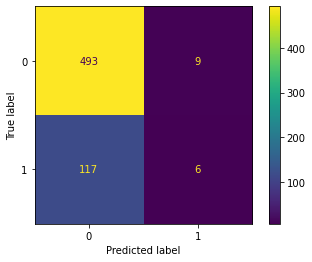

In [249]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class predictions
y_pred = logreg1.predict(test_full)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

Very limited improvement.

## 6. Complex Feature Engineering